In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import warnings

from torchsummary import summary
from pthflops import count_ops
warnings.filterwarnings('ignore')


torch.cuda.empty_cache()

In [4]:
#!unzip /content/Natural-Faces.zip
# import os, random
# import shutil

# m=10

# src_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/train/contempt/"
# dst_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/test/contempt/"

# file_list = os.listdir(src_dir)

# for i in range(m):
    
#     a = random.choice(file_list)
#         #file_list.remove(a)
#     shutil.move(src_dir + a, dst_dir+ a)

In [5]:
def load_data(train_path, test_path, batch_size,input_size,mn,sd,shuffle_test=False):
    
    ######## Write your code here ########
    transform_dict={"src":transforms.Compose([transforms.Resize(size=input_size),transforms.RandomHorizontalFlip(),transforms.RandomAdjustSharpness(sharpness_factor=0.3),
            transforms.RandomVerticalFlip(),transforms.ToTensor(),transforms.Normalize(mean=mn,std=sd)])}

    train=datasets.ImageFolder(root=train_path,transform=transform_dict["src"],)
    
    labelslist=train.class_to_idx
    dataset_size = len(train)
    
    train_size = int(round(0.85 * dataset_size))
    val_size = int(round(0.15 * dataset_size))
    

    train_dataset,val_dataset = torch.utils.data.random_split(train,[train_size,val_size])
    test_dataset=datasets.ImageFolder(root=test_path,transform=transform_dict["src"])
    
    

    print('Size Of Train Dataset',len(train_dataset))
    print('Size Of Test Dataset',len(test_dataset))
    print('Size Of Validation Dataset',len(val_dataset))
   

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    shuffle=False, drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
 
      
    return data_loader_train, data_loader_test,data_loader_val,labelslist

In [6]:
#model_ft = models.resnet50(pretrained=True)
#ct = 0
#for child in model_ft.children():
#ct += 1
#if ct < 7:
#    for param in child.parameters():
#        param.requires_grad = False

In [7]:
def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  

# Natural Faces: 
	
# M: [0.5236, 0.5236, 0.5236]
# SD:[0.2351, 0.2351, 0.2351]


# Tiny:

# M: [0.5422, 0.4674, 0.4349]
# SD: [0.2665, 0.2500, 0.2517]

# Masked-Fer2013:

# M: [0.4652, 0.5198, 0.5736]
# SD: [0.2354, 0.2363, 0.2666]

In [8]:
def define_model(out_ftrs):
    model=torchvision.models.vgg16(weights=False)
    # model.fc = torch.nn.Sequential(
    #     torch.nn.Linear(
    #         in_features=1000,
    #         out_features=out_ftrs
    #     )
        

    # )

    return model

    

In [9]:
def img_show(train_loader,lablist):

    
    
    images,labels=next(iter(train_loader))
    
    print(f"Images batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
    print(lablist)
    
    figure = plt.figure(figsize=(5, 5))
    cols, rows = 3, 3             #Displays 9 images in a 3*3 grid
    for i in range(1, cols * rows + 1):

        img = images[i].squeeze()
        img_label = labels[i]
        
        label=(list(lablist.keys())[list(lablist.values()).index(img_label)])
        
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    



In [10]:
def grp_show(x,y,label,col,x_label,y_label,title):
    
    for i in range(0,len(y)):
      plt.plot(x, y[i], col[i], label=label[i])
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

 


In [11]:
def train_model(num_epochs,train_loader,val_loader):
    model.train()
    Train_steps = len(train_loader)
    Val_steps=len(val_loader)
    print('Total Steps',Train_steps)
    t1 = time.time()

    acclist_train=[]
    acclist_val=[]
    losslist_train=[]
    losslist_val=[]
    epc=[]
    cons_epchs=0
    loss_criteria=0.0001
    last_loss=np.Inf
    verbose=10
    

    for epoch in range(num_epochs):
        
        exp_lr_scheduler.step()
        print('Epoch:', epoch+1,'LR:', exp_lr_scheduler.get_lr())
        
        
        correct=0
        total=0
        loss_train=0
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)#Feedforward
            loss = criterion(outputs, labels)
            optimizer.zero_grad()#Gradient
            loss.backward()#Weights update
            optimizer.step()

            total+= labels.size(0) 

            _,predicted = torch.max(outputs.data, 1) #1 so that all the data is on the same line

            correct+= (predicted == labels).sum().item()
            loss_train+=loss.item()
            if (i + 1)  == Train_steps:

                  correct_v = 0                                                 #Validation Loop
                  total_v = 0
                  loss_v=0
                  for dataVal in val_loader:
                      images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                      outputs_v = model(images_v)
                      loss=criterion(outputs_v,labels_v)
                      _, predicted_v = torch.max(outputs_v.data, 1)
                      correct_v += (predicted_v == labels_v).sum().item()
                      total_v += labels_v.size(0)
                      loss_v+=loss.item()
              
                  print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.4f},'
                      .format(epoch + 1, num_epochs, loss_train/Train_steps, loss_v/Val_steps, (correct / total) * 100, (correct_v / total_v) * 100))
                  
                  acclist_train.append((correct / total) * 100)
                  acclist_val.append((correct_v / total_v) * 100)
                  losslist_train.append(loss_train/Train_steps)
                  losslist_val.append(loss_v/Val_steps)
                  epc.append(epoch+1)

                  
                  
                  current_loss=loss_v/Val_steps

                  if (last_loss-current_loss)<=loss_criteria:
                      cons_epchs += 1
                      last_loss = current_loss
                      
                      if cons_epchs >= verbose:
                        print('Loss Did Not Improve by more than 0.0001 for 10 epochs..Stopping')
                        print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
                        return model,acclist_train,acclist_val,losslist_train,losslist_val,epc

                  else:
                    cons_epchs = 0

                  

 
               
    print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
    return model,acclist_train,acclist_val,losslist_train,losslist_val,epc

In [12]:
from torch.cuda import device
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def test_model(model,test_loader):
    model.eval() 

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad(): 
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
        
        
        print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
        ConfusionMatrixDisplay(conf_mat).plot()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size Of Train Dataset 27625
Size Of Test Dataset 9837
Size Of Validation Dataset 4875
Images batch shape: torch.Size([32, 3, 48, 48])
Labels batch shape: torch.Size([32])
{'admiration': 0, 'amazement': 1, 'angry': 2, 'ecstasy': 3, 'fear': 4, 'grief': 5, 'joy': 6, 'loathing': 7, 'rage': 8, 'sad': 9, 'surprise': 10, 'terror': 11, 'vigilance': 12}


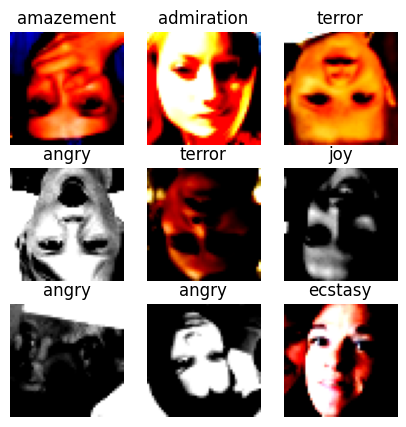

Device: cuda:0
Total Steps 864
Epoch: 1 LR: [0.009980277018784454]
Epoch [1/50], Training Loss: 2.5011, Validation Loss: 2.0956, Training Accuracy: 13.94%, Validation Accuracy: 16.4718,
Epoch: 2 LR: [0.009931100837462445]
Epoch [2/50], Training Loss: 2.0688, Validation Loss: 2.0247, Training Accuracy: 16.60%, Validation Accuracy: 17.3333,
Epoch: 3 LR: [0.009862541403385768]
Epoch [3/50], Training Loss: 2.0204, Validation Loss: 1.9828, Training Accuracy: 18.78%, Validation Accuracy: 19.7744,
Epoch: 4 LR: [0.009774869058090914]
Epoch [4/50], Training Loss: 1.9884, Validation Loss: 1.9781, Training Accuracy: 20.11%, Validation Accuracy: 19.3846,
Epoch: 5 LR: [0.00966842957143696]
Epoch [5/50], Training Loss: 1.9409, Validation Loss: 1.9252, Training Accuracy: 23.31%, Validation Accuracy: 24.6769,
Epoch: 6 LR: [0.009543642776065642]
Epoch [6/50], Training Loss: 1.8783, Validation Loss: 1.9766, Training Accuracy: 26.68%, Validation Accuracy: 25.2513,
Epoch: 7 LR: [0.009401000909533557]
Epoc

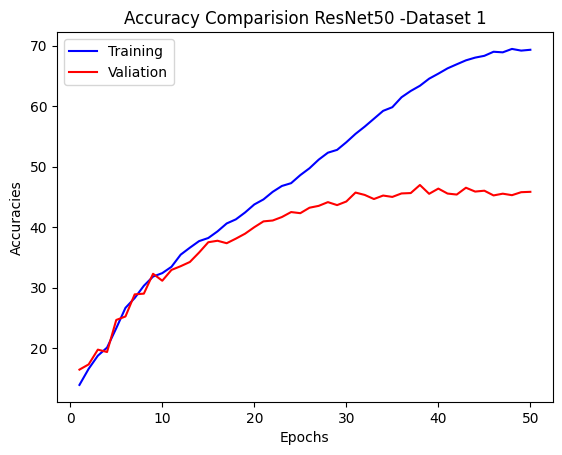

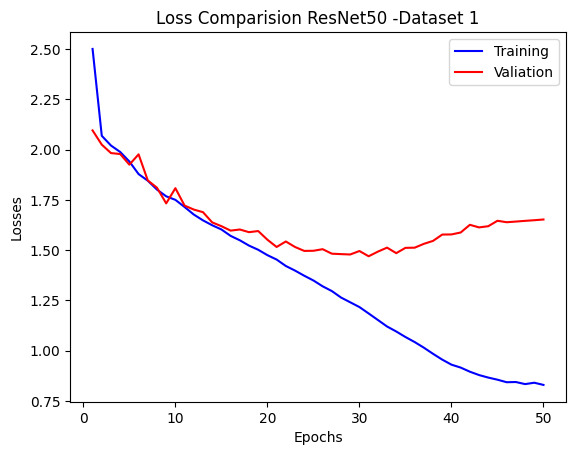

Test Accuracy of the model on the 9837 test images: 49.8322659347362 %


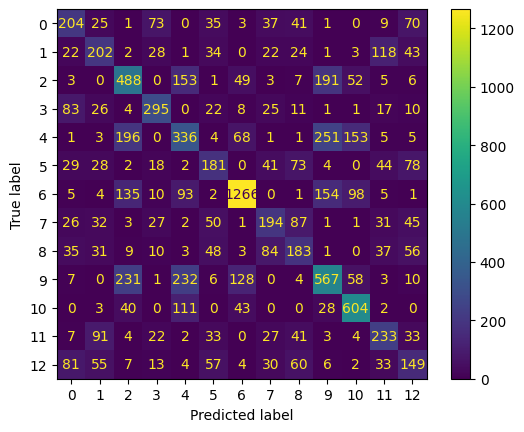

In [16]:

train_paths=['C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/tiny/train']
test_paths=['C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Dataset/tiny/test']
mn=[[0.5236, 0.5236, 0.5236],[0.5422, 0.4674, 0.4349],[0.4652, 0.5198, 0.5736],[0.5074, 0.5074, 0.5074]]
sd=[[0.2351, 0.2351, 0.2351],[0.2665, 0.2500, 0.2517],[0.2354, 0.2363, 0.2666],[0.2551, 0.2551, 0.2551]]

filepath='C:/Users/raqui/Documents/COMP 6721 assignment/Project/AI_Project_Group_K-main/Models'
batch_size=32
image_size=(48,48)
num_epochs=50
learning_rate=0.01
model_name='ResNet50'

for i in range (0,len(test_paths)):
    train_folder=train_paths[i]
    test_folder=test_paths[i]
    train_loader,test_loader,val_loader,lablist=load_data(train_folder,test_folder,batch_size,image_size,mn[i],sd[i])
    
    # mean, std = batch_mean_and_sd(train_loader)
    # print("mean and std: \n", mean, std)
    
    img_show(train_loader,lablist)
    model=torchvision.models.resnet50(weights=False)#model reinitialized to prevent transfer learning on the other data sets
    # print(model)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    exp_lr_scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0, last_epoch=- 1, verbose=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    model.to(device)
    
    # print('----------PARAMETERS----------')
    # summary(model, (3,48,48))
    # print('----------FLOPS----------')
    # count_ops(model, torch.rand(1,3,48,48).to(device))
    

    model,t_acc,v_acc,t_loss,v_loss,epc=train_model(num_epochs,train_loader,val_loader)
    grp_show(epc,[t_acc,v_acc],['Training','Valiation'],['b','r'],'Epochs','Accuracies','Accuracy Comparision '+model_name+' -'+'Dataset '+str(i+1))
    grp_show(epc,[t_loss,v_loss],['Training','Valiation'],['b','r'],'Epochs','Losses','Loss Comparision '+model_name+' -'+'Dataset '+str(i+1))
   
    test_model(model,test_loader)
    torch.save(model, filepath+str(i))
    torch.cuda.empty_cache()

    
    
    
